In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from patsy import dmatrices

**Quality Start (QS) and Really Bad Start (RBS) metrics to quantify goalie performance were developed by Rob Bollman of the Hockey Abstract. Bollman defines a QS as a situation in which a starting goalie's ultimate game save percentage meets or exceeds the overall season mean save percentage. Hence, the bar for earning a QS changes from season to season and QS results can only be finalized after a regular season conclusion. On the other hand, Bollman defined a constant threshold of a less than 85% game save percentage to assign a starting goalie an RBS. Note that QS + RBS != total Games Started (GS) because of the usual gap between 85% and the season mean percentage.**

**This time, I am interested in looking at the influence of goalie age (known henceforth as Age) and "wear-and-tear" on RBS measurements in particular from season to season. We will evaluate season RBS: GS ratios, noting that higher ratios reflect more negatively on goalies. In this simpler exercise, I set the season RBS:GS ratio as a response/dependent/endogenous/target/etc. variable. I will use Age as an explanatory/independent/exogenous/feature/etc. variable. I generally hypothesize that as Age increases, the season RBS-to-GS ratio will also increase.**

**Cumulative NHL minutes and seasons played up to each NHL season would also likely be good explanatory variables. However, they will not figure in this exploration because they were not recorded in columns of this goalie data table from [Hockey Reference](https://hockey.reference.com). The total minutes and seasons data can be drawn from individual player pages on Hockey Reference, but exporting the individual goalie tables one-by-one or writing a script to do so will be left for another time. Since hockey players tend to start training fairly young at similar ages and there are few late starters due to the difficulty of learning to skate, I regard age as a good barometer for wear-and-tear. NHL season and minute totals also do not capture time spent playing in minor and youth leagues; some players need more time in the minors before being called up to The Show.**

In [2]:
df_g = pd.read_csv('nhl_dataset/goalie_stats.csv', encoding = 'utf-8')
df_g.set_index(['Player_ID'])
df_g.tail(10)

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,...,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct
6640,2022,REG,vanecvi01,Vitek Vanecek,False,26,WSH,Washington Capitals,False,False,...,99.0,0.88,0,0.0,0.0,0.0,20.0,5.0,15.0,75.0
6641,2022,REG,varlasi01,Semyon Varlamov,False,33,NYI,New York Islanders,False,False,...,95.0,4.65,0,0.0,0.0,0.0,19.0,3.0,16.0,84.2
6642,2022,REG,vasilan02,Andrei Vasilevskiy,False,27,TBL,Tampa Bay Lightning,False,False,...,90.0,17.72,0,1.0,1.0,6.0,15.0,7.0,8.0,53.3
6643,2022,REG,vejmeka01,Karel Vejmelka,False,25,ARI,Arizona Coyotes,False,False,...,110.0,-14.78,0,0.0,0.0,0.0,3.0,2.0,1.0,33.3
6644,2022,REG,vladada01,Daniel Vladar,False,24,CGY,Calgary Flames,False,False,...,101.0,-0.46,0,1.0,1.0,0.0,5.0,1.0,4.0,80.0
6645,2022,REG,wedgesc01,Scott Wedgewood,False,29,TOT,Total,False,True,...,97.0,3.27,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6646,2022,REG,wedgesc01,Scott Wedgewood,False,29,ARI,Arizona Coyotes,True,False,...,96.0,3.65,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6647,2022,REG,wedgesc01,Scott Wedgewood,False,29,DAL,Dallas Stars,True,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6648,2022,REG,wedgesc01,Scott Wedgewood,False,29,NJD,New Jersey Devils,True,False,...,NaN,NaN,0,0.0,0.0,0.0,18.0,6.0,12.0,66.7
6649,2022,REG,wolljo01,Joseph Woll,False,23,TOR,Toronto Maple Leafs,False,False,...,NaN,NaN,0,0.0,0.0,2.0,NaN,NaN,NaN,NaN


**Goalie QS and RBS statistics were consistently recorded starting in the 2007 - 2008 season, so we filter for data starting that season. Also, the hockey meta begins shifting more toward a heavier speed and skill emphasis after this point.** 

In [3]:
df_g_2008 = df_g[df_g['Season'] >= 2008]
df_g_2008.tail(20)

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,...,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct
6630,2022,REG,sparkga01,Garret Sparks,False,28,LAK,Los Angeles Kings,False,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6631,2022,REG,staloal01,Alex Stalock,False,34,SJS,San Jose Sharks,False,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6632,2022,REG,stolaan01,Anthony Stolarz,False,28,ANA,Anaheim Ducks,False,False,...,89.0,8.24,0,1.0,1.0,2.0,4.0,2.0,2.0,50.0
6633,2022,REG,subbama01,Malcolm Subban,False,28,BUF,Buffalo Sabres,False,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6634,2022,REG,swaymje01,Jeremy Swayman,False,23,BOS,Boston Bruins,False,False,...,93.0,7.32,0,0.0,0.0,6.0,15.0,5.0,10.0,66.7
6635,2022,REG,talboca01,Cam Talbot,False,34,MIN,Minnesota Wild,False,False,...,95.0,6.38,0,1.0,1.0,2.0,15.0,4.0,11.0,73.3
6636,2022,REG,tarasda02,Daniil Tarasov,False,22,CBJ,Columbus Blue Jackets,False,False,...,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6637,2022,REG,thomplo01,Logan Thompson,False,24,VEG,Vegas Golden Knights,False,False,...,93.0,3.92,0,0.0,0.0,0.0,17.0,3.0,14.0,82.4
6638,2022,REG,tokardu01,Dustin Tokarski,False,32,BUF,Buffalo Sabres,False,False,...,109.0,-7.30,0,0.0,0.0,0.0,6.0,3.0,3.0,50.0
6639,2022,REG,ullmali01,Linus Ullmark,False,28,BOS,Boston Bruins,False,False,...,90.0,10.83,0,1.0,1.0,4.0,3.0,0.0,3.0,100.0


**We select for qualifying goalies passing a threshold of starting at least 10 games to filter out fluke metrics from players with even less playing time.**

In [4]:
df_g_2008_qual = df_g_2008[df_g_2008['GS'] >= 10].copy(deep = True)
df_g_2008_qual.tail()

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,...,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct
6642,2022,REG,vasilan02,Andrei Vasilevskiy,False,27,TBL,Tampa Bay Lightning,False,False,...,90.0,17.72,0,1.0,1.0,6.0,15.0,7.0,8.0,53.3
6643,2022,REG,vejmeka01,Karel Vejmelka,False,25,ARI,Arizona Coyotes,False,False,...,110.0,-14.78,0,0.0,0.0,0.0,3.0,2.0,1.0,33.3
6644,2022,REG,vladada01,Daniel Vladar,False,24,CGY,Calgary Flames,False,False,...,101.0,-0.46,0,1.0,1.0,0.0,5.0,1.0,4.0,80.0
6645,2022,REG,wedgesc01,Scott Wedgewood,False,29,TOT,Total,False,True,...,97.0,3.27,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6646,2022,REG,wedgesc01,Scott Wedgewood,False,29,ARI,Arizona Coyotes,True,False,...,96.0,3.65,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


**We create a column keeping track of season RBS-to-GS ratios per player.**

In [5]:
df_g_2008_qual['RBS_GS_ratio'] = df_g_2008_qual['RBS'] / df_g_2008_qual['GS']

In [6]:
df_g_2008_qual['RBS_GS_ratio'].isnull()

3572    False
3573    False
3574    False
3575    False
3577    False
        ...  
6642    False
6643    False
6644    False
6645    False
6646    False
Name: RBS_GS_ratio, Length: 1131, dtype: bool

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
df_g_2008_qual.sort_values(by = 'RBS_GS_ratio', ascending = False)

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,Pos1,GP,GS,W,L,TOSL,GA,SA,SV,SV_Pct,GAA,SO,GPS,MIN,QS,QS_Pct,RBS,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct,RBS_GS_ratio
3709,2009,REG,josepcu01,Curtis Joseph,False,41,TOR,Toronto Maple Leafs,False,False,G,21,11.0,5.0,9.0,1.0,50,383.0,333.0,0.869,3.57,0,0.6,841.0,2.0,0.182,5.0,143.0,-14.95,0,0.0,0.0,0.0,11.0,3.0,8.0,72.7,0.454545
3730,2009,REG,mckenmi01,Mike McKenna,False,25,TBL,Tampa Bay Lightning,False,False,G,15,14.0,4.0,8.0,1.0,46,406.0,360.0,0.887,3.56,1,1.4,776.0,4.0,0.286,6.0,124.0,-8.85,0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.428571
4472,2017,REG,coreaja01,Jared Coreau,False,25,DET,Detroit Red Wings,False,False,G,14,14.0,5.0,4.0,3.0,41,362.0,321.0,0.887,3.46,2,1.0,712.0,5.0,0.357,6.0,131.0,-9.67,0,0.0,0.0,0.0,3.0,1.0,2.0,66.7,0.428571
6558,2022,REG,hammoan01,Andrew Hammond,False,33,TOT,Total,False,True,G,11,10.0,4.0,5.0,1.0,38,314.0,276.0,0.879,3.89,0,0.8,586.0,4.0,0.400,4.0,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.400000
3926,2011,REG,mcelhcu01,Curtis McElhinney,False,27,ANA,Anaheim Ducks,True,False,G,21,16.0,6.0,9.0,1.0,57,516.0,459.0,0.890,3.43,2,1.7,996.0,6.0,0.375,6.0,127.0,-12.05,0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,2015,REG,darlisc01,Scott Darling,False,26,CHI,Chicago Blackhawks,False,False,G,14,13.0,9.0,4.0,0.0,27,419.0,392.0,0.936,1.95,1,3.6,833.0,10.0,0.769,0.0,75.0,8.76,0,0.0,0.0,0.0,7.0,0.0,7.0,100.0,0.000000
6360,2016,POST,holtbbr01,Braden Holtby,False,26,WSH,Washington Capitals,NaN,NaN,G,12,12.0,6.0,6.0,NaN,21,363.0,342.0,0.942,1.72,2,NaN,732.0,9.0,0.750,0.0,70.0,9.06,0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.000000
3930,2011,REG,montoal01,Al Montoya,False,25,NYI,New York Islanders,False,False,G,20,18.0,9.0,5.0,5.0,46,585.0,539.0,0.921,2.39,1,4.1,1154.0,13.0,0.722,0.0,90.0,4.96,0,1.0,1.0,2.0,9.0,3.0,6.0,66.7,0.000000
4790,2020,REG,driedch01,Chris Driedger,False,25,FLA,Florida Panthers,False,False,G,12,11.0,7.0,2.0,1.0,22,354.0,332.0,0.938,2.05,1,3.1,643.0,8.0,0.727,0.0,69.0,10.01,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000


**We need to account for goalies traded or waived during the regular season that played on multiple teams. These goalies are redundantly listed per season with individual teams capturing their team statistics and under the team label `"TOT"`, which captures their entire season statistics.**

In [9]:
df_g_2008_qual[df_g_2008_qual.Team_ID == 'TOT']

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,Pos1,GP,GS,W,L,TOSL,GA,SA,SV,SV_Pct,GAA,SO,GPS,MIN,QS,QS_Pct,RBS,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct,RBS_GS_ratio
3574,2008,REG,auldal01,Alex Auld,False,27,TOT,Total,False,True,G,32,28.0,12.0,13.0,5.0,77,827.0,750.0,0.907,2.68,3,4.9,1722.0,12.0,0.429,6.0,102.0,-1.87,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.214286
3583,2008,REG,bryzgil01,Ilya Bryzgalov,False,27,TOT,Total,False,True,G,64,62.0,28.0,25.0,6.0,147,1829.0,1682.0,0.920,2.44,3,13.5,3614.0,37.0,0.597,5.0,88.0,19.15,0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,0.080645
3610,2008,REG,holmqjo01,Johan Holmqvist,False,29,TOT,Total,False,True,G,47,47.0,21.0,16.0,6.0,129,1164.0,1035.0,0.889,3.04,2,4.5,2549.0,19.0,0.404,17.0,122.0,-23.26,0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.361702
3614,2008,REG,huetcr01,Cristobal Huet,False,32,TOT,Total,False,True,G,52,51.0,32.0,14.0,6.0,118,1479.0,1361.0,0.920,2.32,4,11.1,3049.0,31.0,0.608,6.0,88.0,16.36,0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,0.117647
3653,2008,REG,smithmi01,Mike Smith,False,25,TOT,Total,False,True,G,34,32.0,15.0,19.0,0.0,84,848.0,764.0,0.901,2.59,3,4.4,1946.0,14.0,0.438,8.0,109.0,-6.97,0,1.0,1.0,12.0,NaN,NaN,NaN,NaN,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6543,2022,REG,fleurma01,Marc-Andre Fleury,False,37,TOT,Total,False,True,G,56,56.0,28.0,23.0,5.0,159,1732.0,1573.0,0.908,2.90,4,9.7,3285.0,28.0,0.500,15.0,99.0,2.08,0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,0.267857
6551,2022,REG,gillijo01,Jon Gillies,False,28,TOT,Total,False,True,G,20,15.0,3.0,10.0,2.0,62,550.0,488.0,0.887,3.70,0,1.9,1005.0,6.0,0.400,3.0,121.0,-10.85,0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.200000
6558,2022,REG,hammoan01,Andrew Hammond,False,33,TOT,Total,False,True,G,11,10.0,4.0,5.0,1.0,38,314.0,276.0,0.879,3.89,0,0.8,586.0,4.0,0.400,4.0,NaN,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.400000
6579,2022,REG,kahkoka01,Kaapo Kahkonen,False,25,TOT,Total,False,True,G,36,33.0,14.0,14.0,4.0,93,1056.0,963.0,0.912,2.87,0,6.3,1947.0,22.0,0.667,6.0,95.0,5.21,0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,0.181818


**If the same `Player_ID` shows up multiple times in a season, we use the row labeled with `Team_ID == "TOT"` and delete the other individual team listings. Since `"TOT"` `MIN` will always be greater or equal than the individual team `MIN` for a season, one approach for eliminating `Player_ID` season duplicates would be to filter for the row with the maximum `MIN` per `Season`. Another approach would be to eliminate the `Team_ID` strings that do not match `"TOT"`.**

In [10]:
df_g_2008_qual_tot = df_g_2008_qual.sort_values('MIN', ascending = False).drop_duplicates(subset = ['Season', 'Player_ID']) #Drop duplicates of `Player_ID` if they exist by lower `MIN` in a `Season`, which should correspond to `Team_ID` == "TOT".

In [11]:
df_g_2008_qual_tot.shape #We check the size of our filtered DataFrame. The number of rows appears reasonable for the number of seasons the DataFrame spans and goals in the league.

(951, 38)

In [12]:
df_g_2008_qual_tot.nsmallest(n = 20, columns = "RBS_GS_ratio")

,Season,Game_Type,Player_ID,Player_Name,Hof,Age,Team_ID,Team_Name,Team_Bkdwn_Flag,Seas_Sum_Flag,Pos1,GP,GS,W,L,TOSL,GA,SA,SV,SV_Pct,GAA,SO,GPS,MIN,QS,QS_Pct,RBS,GA_Pct_Rel,GSAA,G,A,PTS,PIM,soAtt,soMade,soMiss,soPct,RBS_GS_ratio
4963,2021,REG,vasilan02,Andrei Vasilevskiy,False,26,TBL,Tampa Bay Lightning,False,False,G,42,42.0,31.0,10.0,1.0,93,1237.0,1144.0,0.925,2.21,5,9.6,2524.0,24.0,0.571,0.0,82.0,20.96,0,4.0,4.0,0.0,3.0,1.0,2.0,66.7,0.000000
4133,2014,REG,anderfr01,Frederik Andersen,False,24,ANA,Anaheim Ducks,False,False,G,28,24.0,20.0,5.0,0.0,60,783.0,723.0,0.923,2.29,0,5.6,1569.0,12.0,0.500,0.0,89.0,7.47,0,1.0,1.0,0.0,4.0,0.0,4.0,100.0,0.000000
4933,2021,REG,nedelal01,Alex Nedeljkovic,False,25,CAR,Carolina Hurricanes,False,False,G,23,23.0,15.0,5.0,3.0,44,648.0,604.0,0.932,1.90,3,5.5,1392.0,15.0,0.652,0.0,74.0,15.70,0,1.0,1.0,2.0,3.0,0.0,3.0,100.0,0.000000
4244,2014,REG,talboca01,Cam Talbot,False,26,NYR,New York Rangers,False,False,G,21,19.0,12.0,6.0,1.0,33,560.0,527.0,0.941,1.64,3,5.2,1211.0,16.0,0.842,0.0,68.0,15.25,0,0.0,0.0,0.0,3.0,1.0,2.0,66.7,0.000000
3930,2011,REG,montoal01,Al Montoya,False,25,NYI,New York Islanders,False,False,G,20,18.0,9.0,5.0,5.0,46,585.0,539.0,0.921,2.39,1,4.1,1154.0,13.0,0.722,0.0,90.0,4.96,0,1.0,1.0,2.0,9.0,3.0,6.0,66.7,0.000000
4516,2017,REG,mcelhcu01,Curtis McElhinney,False,33,TOT,Total,False,True,G,21,15.0,8.0,8.0,2.0,51,616.0,565.0,0.917,2.70,1,3.9,1135.0,9.0,0.600,0.0,96.0,2.31,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.000000
4960,2021,REG,ullmali01,Linus Ullmark,False,27,BUF,Buffalo Sabres,False,False,G,20,20.0,9.0,6.0,3.0,49,591.0,542.0,0.917,2.63,0,4.1,1117.0,11.0,0.550,0.0,90.0,5.45,0,0.0,0.0,0.0,13.0,1.0,12.0,92.3,0.000000
3968,2012,REG,budajpe01,Peter Budaj,False,29,MTL,Montreal Canadiens,False,False,G,17,17.0,5.0,7.0,5.0,44,508.0,464.0,0.913,2.55,0,3.1,1037.0,8.0,0.471,0.0,100.0,-0.08,0,3.0,3.0,2.0,15.0,7.0,8.0,53.3,0.000000
4300,2015,REG,kinkake01,Keith Kinkaid,False,25,NJD,New Jersey Devils,False,False,G,19,13.0,6.0,5.0,4.0,40,469.0,429.0,0.915,2.59,0,2.8,925.0,8.0,0.615,0.0,100.0,0.03,0,0.0,0.0,0.0,12.0,4.0,8.0,66.7,0.000000
3701,2009,REG,hardijo01,Josh Harding,False,24,MIN,Minnesota Wild,False,False,G,19,11.0,3.0,9.0,1.0,32,453.0,421.0,0.929,2.21,0,3.8,870.0,5.0,0.455,0.0,77.0,9.45,0,0.0,0.0,2.0,2.0,1.0,1.0,50.0,0.000000


# Exploratory data analysis

**Let us look at the RBS-to-GS ratio distribution per season.**

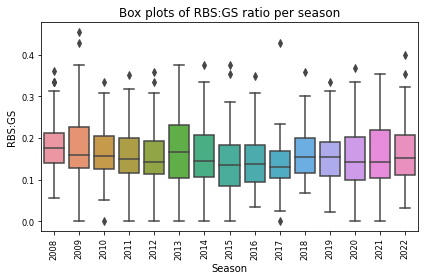

In [13]:
ax = sns.boxplot(data = df_g_2008_qual_tot, x = "Season", y = "RBS_GS_ratio")
ax.xaxis.set_tick_params(labelsize = 'small', labelrotation = 90)
ax.set_ylabel('RBS:GS')
ax.yaxis.set_tick_params(labelsize = 'small')
ax.set_title('Box plots of RBS:GS ratio per season')
plt.tight_layout()
plt.show()

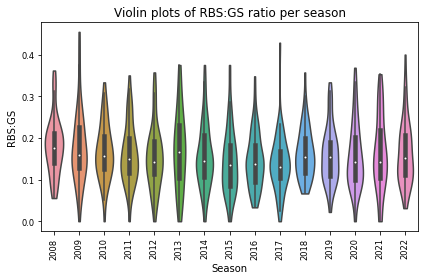

In [14]:
ax = sns.violinplot(data = df_g_2008_qual_tot, x = "Season", y = "RBS_GS_ratio", cut = 0.) #Note that we have y-axis truncation at 0 specified with `cut = 0` in this violin plot as an artifact of Gaussian KDE estimation. As such, the box plot is probably more appropriate for visualization.
ax.xaxis.set_tick_params(labelsize = 'small', labelrotation = 90)
ax.set_ylabel('RBS:GS')
ax.yaxis.set_tick_params(labelsize = 'small')
ax.set_title('Violin plots of RBS:GS ratio per season')
plt.tight_layout()
plt.show()

**It doesn't look like RBS:GS has remained relatively stable through all the seasons based on the box and violin plots. Let's run a smooth regression to see mean RBS:GS curve is indeed fairly flat.**

**Let us plot the RBS-to-GS ratio for each `Player_ID` since 2008 with year as the x-axis.**